## Imports, Classes, and Constants

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn.utils import shuffle
from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

RANDOM_SEED = 42

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])
    
mcu_subset = pd.read_csv("./data/mcu_subset.csv")

## Data Preprocessing

In [26]:
pd.DataFrame(mcu_subset['character'].value_counts())

,character
TONY STARK,1976
STEVE ROGERS,1024
THOR,959
NATASHA ROMANOFF,519
PEPPER POTTS,459
BRUCE BANNER,399
LOKI,377
PETER QUILL,312
ROCKET,246


In [3]:
y = mcu_subset["character"].to_numpy().astype(str)
X = mcu_subset["line"].to_numpy().astype(str)

X, y = shuffle(X, y, random_state=RANDOM_SEED)

X[0:10], y[0:10]

(array(["Yes, I'm not even sure what country Jane's in. Her work on the convergence has made her the world's foremost astronomer.",
        'Calm down!', 'What the hell happened?', 'We’re doing it.',
        'Shut up! And give me some tape! Does anyone have any tape out there!? I want to put some tape over the death button!',
        'Rocket!', 'Loki, turn off the Tesseract or I’ll destroy it! ',
        'What help were you in your cell?',
        'Hm.  Bit ostentatious, don’t you think?',
        'Ah, they deserve it. Plus, it helps ease my conscience.'],
       dtype='<U852'),
 array(['THOR', 'PEPPER POTTS', 'BRUCE BANNER', 'THOR', 'ROCKET',
        'PETER QUILL', 'THOR', 'THOR', 'TONY STARK', 'TONY STARK'],
       dtype='<U16'))

## Models

In [4]:
cross_validator = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
hyperparameter_cross_validator = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
score_method = "balanced_accuracy"

In [5]:
stem_count_vectorizer = StemCountVectorizer(binary=False)
tfidf_transformer = TfidfTransformer()
nb_classifier = MultinomialNB()

In [6]:
count_params = {'vect__stop_words': [None, stopwords.words('english')],
              'vect__ngram_range': [(1,1), (1,2)]}

tfidf_params = {'tfidf__norm': ['l1', 'l2'],
              'tfidf__use_idf': [True, False]}

nb_params = {'clf__alpha': [1e-1, 1e-2, 1e-3],
             'clf__fit_prior': [True, False]}

In [7]:
pipe13 = Pipeline([('vect', stem_count_vectorizer),
                  ('tfidf', tfidf_transformer),
                  ('clf', nb_classifier)])

parameters13 = {**count_params, **tfidf_params, **nb_params}

model13 = GridSearchCV(pipe13, parameters13, cv=hyperparameter_cross_validator, scoring=score_method, n_jobs=-1, verbose=3)

## Nested CV Balanced Accuracy

In [8]:
models = {"model 13": model13}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    results = cross_val_score(model, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=3)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 203.0min remaining: 304.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 203.4min finished


,model 13
fold,
0,0.281300
1,0.266475
2,0.264700
3,0.283169
4,0.288608
mean,0.276850
std,0.009521
max,0.288608


## Confusion Matrix

Balanced Accuracy: 0.276823956066846
Balanced Accuracy: 0.27682395606684607


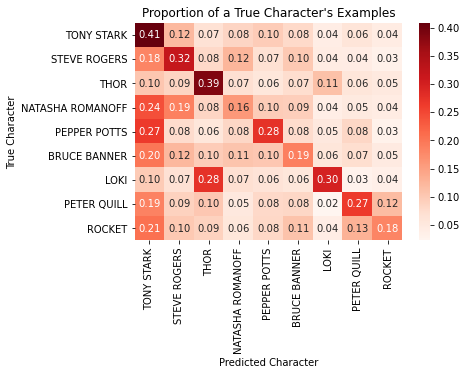

In [27]:
yhat = cross_val_predict(model13, X, y, cv=cross_validator, n_jobs=-1, verbose=4)

main_characters = mcu_subset['character'].value_counts().index.to_numpy()

conf_matrix = pd.DataFrame(metrics.confusion_matrix(y, yhat, labels=main_characters))
normalized_conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
normalized_conf_matrix.columns = pd.Series(main_characters, name="Predicted Character")
normalized_conf_matrix.index = pd.Series(main_characters, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(normalized_conf_matrix)))

In [28]:
prediction_table = pd.DataFrame({"line": X, "true character": y, "predicted character": yhat})
print(X.shape)

#mcu_character_line_movie = pd.DataFrame({"character": mcu["character"], "line": mcu["line"], "movie": mcu["movie"]})

#prediction_table.line = prediction_table.line.astype(str)
#mcu_character_line_movie.line = mcu_character_line_movie.line.astype(str)

#prediction_table = prediction_table.merge(mcu_character_line_movie, left_on=["line", "true character"], right_on=['line', 'character'], how="left")

dump(prediction_table, "./model13_predictions_5_folds.joblib")

prediction_table.head()

(6271,)


,line,true character,predicted character
0,"Yes, I'm not even sure what country Jane's in....",THOR,THOR
1,Calm down!,PEPPER POTTS,TONY STARK
2,What the hell happened?,BRUCE BANNER,TONY STARK
3,We’re doing it.,THOR,BRUCE BANNER
4,Shut up! And give me some tape! Does anyone ha...,ROCKET,PETER QUILL


Above is a table containing the proportion of true examples for each prediction.  The diagonal cells represent the recall for each true label.  The average of our diagonal elements is our balanced accuracy (0.26 from our nested cross validation scoring table, as well as if you calculate it from the matrix).

## Learning Curve

In [13]:
def plot_learning_curve(estimator, title, X, y, axes=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, verbose=3)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return

[learning_curve] Training set sizes: [ 501 1630 2758 3887 5016]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed: 208.0min remaining: 442.0min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed: 358.3min remaining: 168.6min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 456.9min finished


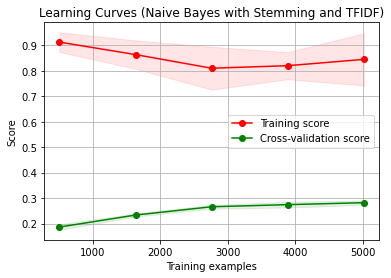

In [14]:
title = "Learning Curves (Naive Bayes with Stemming and TFIDF)"

plot_learning_curve(model13, title, X, y, cv=cross_validator)

## Error as a function of words

Text(0, 0.5, 'accuracy')

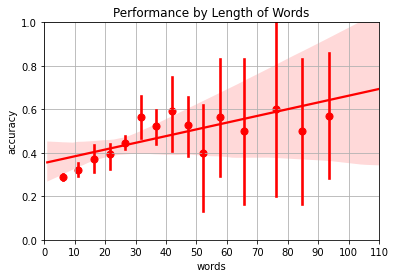

In [115]:
prediction_table['words'] = prediction_table['line'].str.split(" ").str.len()

prediction_table['correct prediction'] = prediction_table['true character'] == prediction_table['predicted character']
prediction_table['correct prediction'] = prediction_table['correct prediction'].astype('int64')

error_by_words = prediction_table.groupby(by='words').mean()
error_by_words.reset_index(drop=False, inplace=True)

plt.grid()
sns.regplot(x = error_by_words['words'].to_numpy(), 
            y = error_by_words['correct prediction'].to_numpy(), 
            color='r', robust = True, x_bins=15)

plt.xticks(np.arange(0,150,10))
plt.xlim(0,110)
plt.ylim(0,1)
plt.title('Performance by Length of Words')
plt.xlabel('words')
plt.ylabel('accuracy')

## Export Model

In [16]:
model13.fit(X,y)
model13.best_params_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 35.9min finished


{'clf__alpha': 0.01,
 'clf__fit_prior': False,
 'tfidf__norm': 'l2',
 'tfidf__use_idf': False,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [18]:
prod_model = Pipeline([('vect', StemCountVectorizer(binary=False, ngram_range=(1,2), stop_words=None)),
                  ('tfidf', TfidfTransformer(norm='l2', use_idf=False)),
                  ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

In [19]:
prod_model.fit(X,y)
dump(prod_model, './front_end/production_model.joblib')

['./front_end/production_model.joblib']